Loading the data from stock_data/AAPL_2020-01-01_2023-01-01.csv
Data Samples 756
NaN values before handling
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
NaN values after handling
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Splitting by ratio
Training samples: 604
Test samples: 152
shape (577, 30, 6) and (577, 5)
Loading existing model from saved_models/GRU_multistep.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


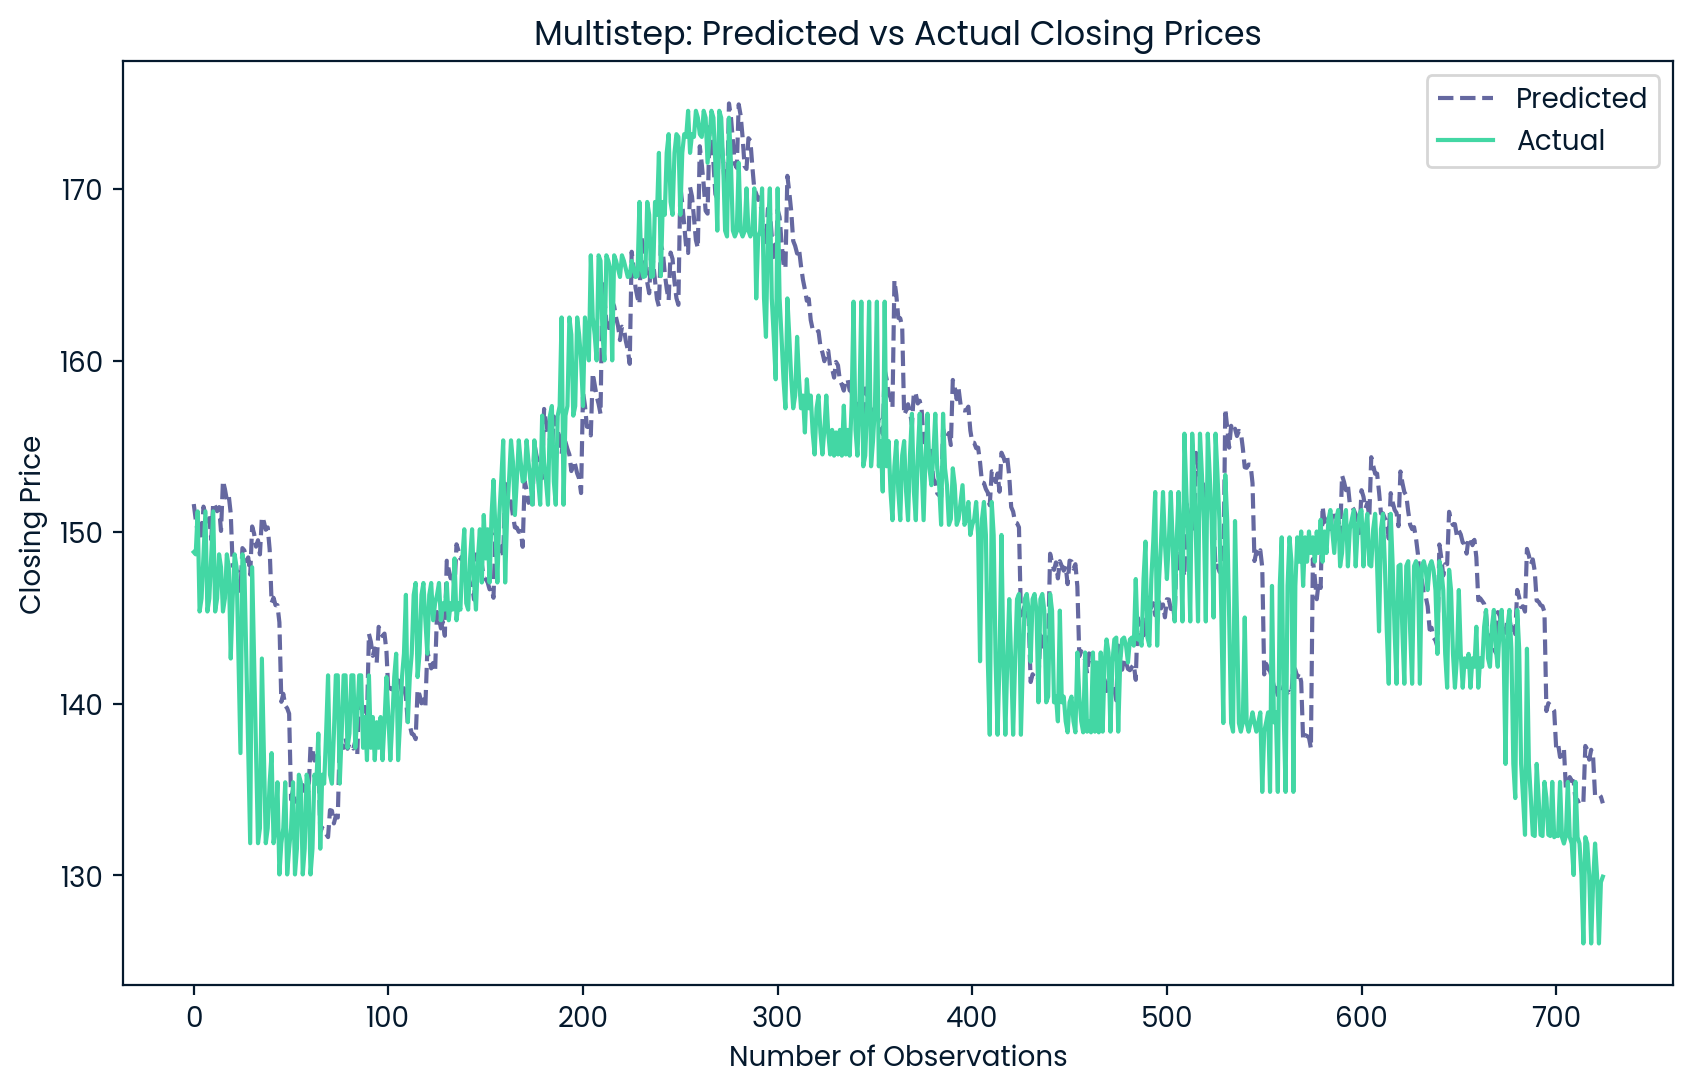

shape (580, 30, 6) and (146, 30, 6) and (580,) and (146,)
Creating a new GRU_multivariate model
Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.5704 - val_loss: 0.1951
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0716 - val_loss: 0.0020
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0117 - val_loss: 0.0017
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0043 - val_loss: 0.0021
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.1962e-04 - val_loss: 0.0011
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.8492e-04 - val_loss: 0.0010
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.0789e-04 - val_loss: 0.0010
Epoch 9/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.3668e-04 - val_loss: 9.8577e-04
Epoch 10/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.6749e-04 - val_loss: 9.9474e-04
Epoch 11/50
19/19 ━━━━━━━

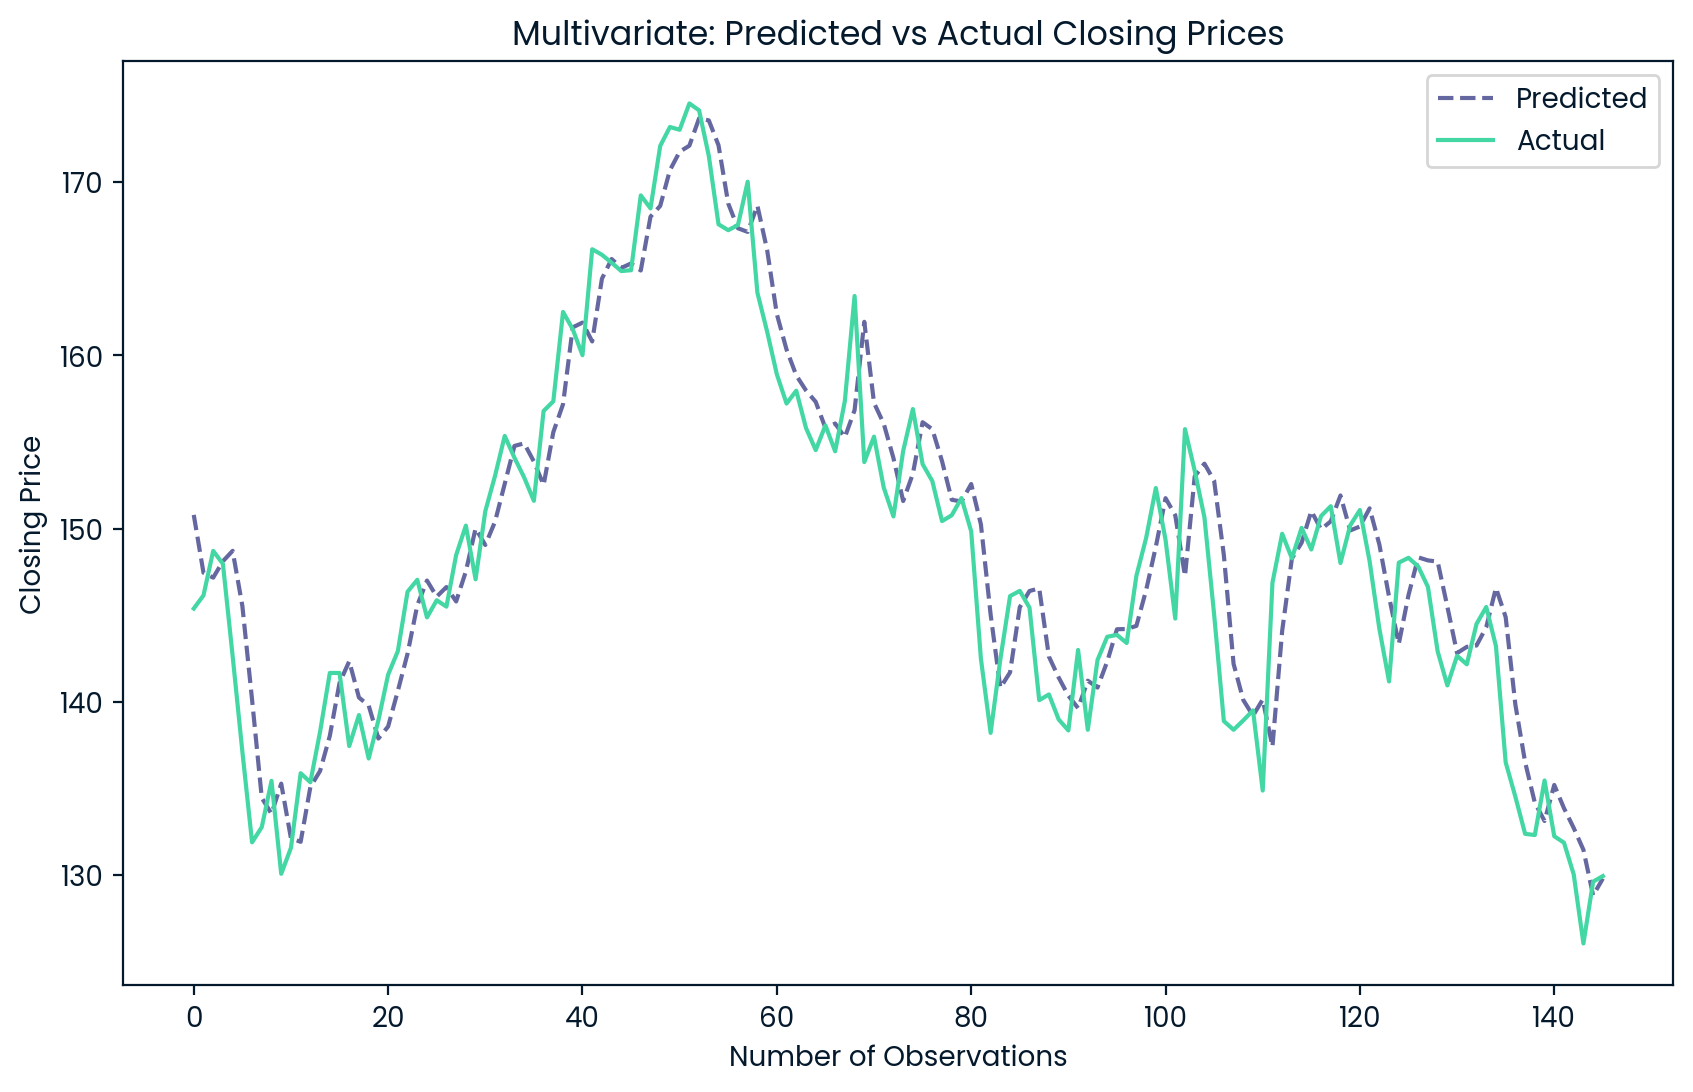

Type <class 'int'> and <class 'int'>: 30
Loading existing model from saved_models/GRU_multivariate_multistep.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


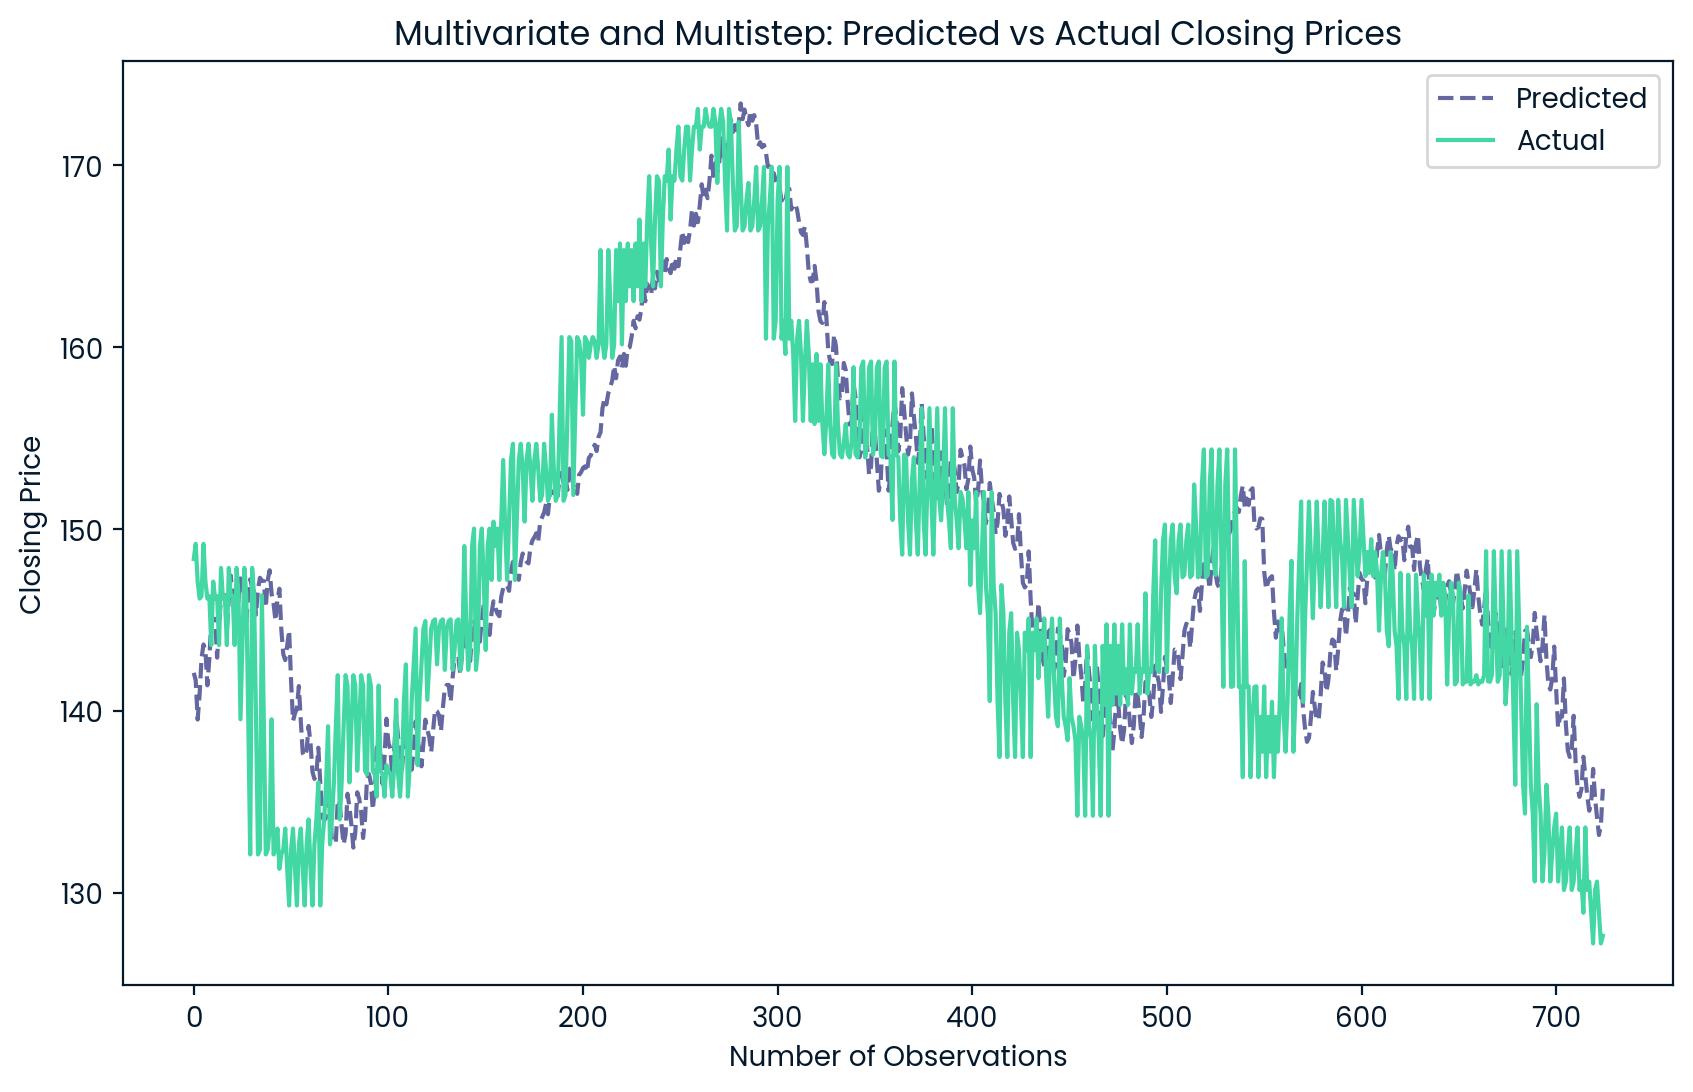

Model workflows completed successfully!


In [4]:
# Stock Price Prediction with Flexible Model Saving and Loading

# Import required libraries
import os
import pandas as pd
import yfinance as yf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, GRU, Input, Dense, Dropout

# %% Model Saving and Loading Utilities
def save_model_with_options(model, model_name, save_dir='saved_models'):
    """
    Save a Keras model with flexible saving options.
    
    Parameters:
    - model: Trained Keras model to save
    - model_name: Name of the model file (without .h5 extension)
    - save_dir: Directory to save the model (default is 'saved_models')
    
    Returns:
    - Full path of the saved model
    """
    # Create save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Construct full save path
    save_path = os.path.join(save_dir, f'{model_name}.h5')
    
    # Save the model
    model.save(save_path)
    print(f"Model saved to {save_path}")
    
    return save_path

def load_or_create_model(model_builder_func, model_name, 
                          load_existing=False, 
                          create_new=False, 
                          save_dir='saved_models', 
                          *args, **kwargs):
    """
    Flexible function to either load an existing model or create a new one.
    """
    save_path = os.path.join(save_dir, f'{model_name}.h5')
    
    # Try to load existing model if requested
    if load_existing and os.path.exists(save_path):
        try:
            print(f"Loading existing model from {save_path}")
            return load_model(save_path)
        except Exception as e:
            print(f"Error loading model: {e}")
            print("Falling back to creating a new model.")
    
    # Create a new model if requested
    if create_new:
        print(f"Creating a new {model_name} model")
        model = model_builder_func(*args, **kwargs)
        return model
    
    raise ValueError("No model loaded or created. Check your parameters.")

# %% Data Loading and Processing Function
def load_process_data(ticker, start_date, end_date, data_dir='stock_data',
                     dealNaN=True, drop_NaN=True, split_by_ratio=False,
                     split_by_date=False, split_by_randomly=True,
                     split_date=None, scale=True, test_size=0.2):
    """Load and process stock data with various options for handling NaN and splitting"""
    feature_columns = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]

    # Create data directory if it doesn't exist
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    # Create file path for stock price data
    file_path = os.path.join(data_dir, f'{ticker}_{start_date}_{end_date}.csv')

    # Load or Download the data
    if os.path.exists(file_path):
        print(f"Loading the data from {file_path}")
        data = pd.read_csv(file_path, index_col='Date', parse_dates=True)
    else:
        print(f"Loading data {ticker} from Yahoo finance")
        data = yf.download(ticker, start_date, end_date)
        data.to_csv(file_path)
        print(f"Data saved to {file_path}")

    result = {'data': data.copy()}
    print(f"Data Samples {len(data)}")

    # Handle NaN values
    if dealNaN:
        print("NaN values before handling")
        print(data.isna().sum())
        if drop_NaN:
            data.dropna(inplace=True)
        else:
            data.fillna(data.mean(), inplace=True)
        print("NaN values after handling")
        print(data.isna().sum())

    # Split data
    if split_by_ratio:
        print('Splitting by ratio')
        train_samples = int((1-test_size) * len(data))
        result['data_train'] = data[:train_samples]
        result['data_test'] = data[train_samples:]
    elif split_by_date:
        print('Splitting by date')
        split_date = pd.to_datetime(split_date)
        result['data_train'] = data[data.index <= split_date]
        result['data_test'] = data[data.index > split_date]
    elif split_by_randomly:
        print('Splitting randomly')
        result['data_train'], result['data_test'] = train_test_split(
            data, test_size=test_size, shuffle=True)

    print(f"Training samples: {len(result['data_train'])}")
    print(f"Test samples: {len(result['data_test'])}")

    # Scale data if requested
    if scale:
        scalers = {}
        scaled_data = pd.DataFrame(index=data.index)

        for column in feature_columns:
            scaler = MinMaxScaler(feature_range=(0, 1))
            scaled_data[column] = scaler.fit_transform(
                data[column].values.reshape(-1, 1)).flatten()
            scalers[column] = scaler

        result['scaled_data'] = scaled_data

    return result, scalers

# %% Data Preparation Functions
def multistep_data(scaler, n_steps, k):
    X, y = [], []
    scaler_array = scaler.values
    for i in range(len(scaler_array) - n_steps - k + 1):
        X.append(scaler_array[i:i + n_steps, :])
        y.append(scaler_array[i + n_steps:i + n_steps + k, scaler.columns.get_loc('Close')])
    
    return np.array(X), np.array(y)

def multivariate_data(scaler, n_steps, feature_columns, target_column):
    X, y = [], []
    
    scaler_array = scaler.values
    for i in range(len(scaler_array) - n_steps):
        X.append(scaler_array[i:i+n_steps])
        y.append(scaler_array[i+n_steps, feature_columns.index(target_column)])
    
    return np.array(X), np.array(y)

def multivariate_multistep_data(scaler, features, target_column, n_steps, k):
    X, y = [], []
    
    scaler_array = scaler.values
    print(f"Type {type(len(scaler_array))} and {type(n_steps)}: {n_steps}")
    for i in range(len(scaler_array) - n_steps - k + 1):
        X.append(scaler_array[i:i+n_steps])
        y.append(scaler_array[i+n_steps:i+n_steps + k, 0])
    
    return np.array(X), np.array(y)

# %% Model Building Functions
def build_multistep_model(n_steps, k):
    """Build a multistep GRU model"""
    model = Sequential()
    model.add(Input(shape=(n_steps, 6)))
    model.add(GRU(50, activation='relu'))
    model.add(Dense(k))
    
    # Recreate the optimizer instance
    optimizer = tf.keras.optimizers.Adam()

    # Compile the model with the new optimizer
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model
def build_multivariate_model(n_steps, n_features):
    """Build a multivariate GRU model"""
    model = Sequential()
    model.add(Input(shape=(n_steps, n_features)))
    model.add(GRU(50, activation='relu'))
    model.add(Dense(1))
    
    # Recreate the optimizer instance
    optimizer = tf.keras.optimizers.Adam()

    # Compile the model with the new optimizer
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model
    # return model

def build_multivariate_multistep_model(n_steps, n_features, k):
    """Build a multivariate multistep GRU model"""
    model = Sequential()
    model.add(Input(shape=(n_steps, n_features)))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(k))
    # Recreate the optimizer instance
    optimizer = tf.keras.optimizers.Adam()

    # Compile the model with the new optimizer
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# %% Configuration Parameters
TICKER = 'AAPL'
START_DATE = '2020-01-01'
END_DATE = '2023-01-01'
N_STEPS = 30
K = 5
FEATURE_COLUMNS = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
TARGET_COLUMN = 'Close'

# %% Load and Process Data
result, scalers = load_process_data(
    ticker=TICKER,
    start_date=START_DATE,
    end_date=END_DATE,
    split_by_date=False,
    split_by_randomly=False,
    split_by_ratio=True,
    split_date='2021-06-01',
    scale=True
)

# %% Multistep Model Workflow
def run_multistep_model_workflow(load_existing=True, create_new=False):
    # Prepare Data
    X, y = multistep_data(result['scaled_data'], N_STEPS, K)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    print(f"shape {X_train.shape} and {y_train.shape}")
    
    # Model Handling with Flexible Options
    multistep_model = load_or_create_model(
        model_builder_func=build_multistep_model, 
        model_name='GRU_multistep', 
        load_existing=load_existing,  # Set to True to load existing model
        create_new=create_new,
        n_steps=N_STEPS, 
        k=K
    )
    
    # Recreate the optimizer instance
    optimizer = tf.keras.optimizers.Adam()
    
    # Compile the model with the new optimizer
    multistep_model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Train Model
    if create_new or not load_existing:
        multistep_model.fit(
            X_train, y_train, 
            epochs=50, 
            batch_size=32, 
            validation_data=(X_test, y_test), 
            verbose=1
        )
    
        # Save Model
        save_model_with_options(multistep_model, 'GRU_multistep')
    
    # Prediction and Visualization
    y_pred_scaled = multistep_model.predict(X_test)
    y_pred = scalers['Close'].inverse_transform(y_pred_scaled)
    y_test_original = scalers['Close'].inverse_transform(y_test)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(y_pred.flatten(), label='Predicted', linestyle='--')
    plt.plot(y_test_original.flatten(), label='Actual', linestyle='-')
    plt.title('Multistep: Predicted vs Actual Closing Prices')
    plt.xlabel('Number of Observations')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()
    
    return multistep_model

def run_multivariate_model_workflow(load_existing=True, create_new=False):
    # Prepare Data
    X, y = multivariate_data(result['scaled_data'], N_STEPS, FEATURE_COLUMNS, TARGET_COLUMN)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    print(f"shape {X_train.shape} and {X_test.shape} and {y_train.shape} and {y_test.shape}")
    
    # Model Handling with Flexible Options
    multivariate_model = load_or_create_model(
        model_builder_func=build_multivariate_model, 
        model_name='GRU_multivariate', 
        load_existing=load_existing,  # Set to True to load existing model
        create_new=create_new,
        n_steps=N_STEPS, 
        n_features=len(FEATURE_COLUMNS)
    )
    
    # Recreate the optimizer instance
    optimizer = tf.keras.optimizers.Adam()
    
    # Compile the model with the new optimizer
    multivariate_model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Train Model
    if create_new or not load_existing:
        multivariate_model.fit(
            X_train, y_train, 
            epochs=50, 
            batch_size=32, 
            validation_data=(X_test, y_test), 
            verbose=1
        )
    
        # Save Model
        save_model_with_options(multivariate_model, 'GRU_multivariate')
    
    # Prediction and Visualization
    y_pred_scaled = multivariate_model.predict(X_test)
    target_column_index = FEATURE_COLUMNS.index('Close')
    
    y_pred_scaled_expanded = np.zeros((y_pred_scaled.shape[0], X_test.shape[2]))
    y_pred_scaled_expanded[:, target_column_index] = y_pred_scaled[:, 0]
    
    y_test_expanded = np.zeros((y_test.shape[0], X_test.shape[2]))
    y_test_expanded[:, target_column_index] = y_test
    
    # Inverse transform for 'Close' column
    y_pred_original = scalers['Close'].inverse_transform(
        y_pred_scaled_expanded[:, target_column_index].reshape(-1, 1)
    ).flatten()
    
    y_test_original = scalers['Close'].inverse_transform(
        y_test_expanded[:, target_column_index].reshape(-1, 1)
    ).flatten()
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(y_pred_original, label='Predicted', linestyle='--')
    plt.plot(y_test_original, label='Actual', linestyle='-')
    plt.title('Multivariate: Predicted vs Actual Closing Prices')
    plt.xlabel('Number of Observations')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()
    
    return multivariate_model

def run_multivariate_multistep_model_workflow(load_existing=True, create_new=False):
    # Prepare Data
    X, y = multivariate_multistep_data(result['scaled_data'], N_STEPS, FEATURE_COLUMNS, N_STEPS, K)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Model Handling with Flexible Options
    multivariate_multistep_model = load_or_create_model(
        model_builder_func=build_multivariate_multistep_model, 
        model_name='GRU_multivariate_multistep', 
        load_existing=load_existing,  # Set to True to load existing model
        create_new=create_new,
        n_steps=N_STEPS, 
        n_features=len(FEATURE_COLUMNS),
        k=K
    )
    
    # Recreate the optimizer instance
    optimizer = tf.keras.optimizers.Adam()
    
    # Compile the model with the new optimizer
    multivariate_multistep_model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Train Model
    if create_new or not load_existing:
        multivariate_multistep_model.fit(
            X_train, y_train, 
            epochs=50, 
            batch_size=32, 
            validation_data=(X_test, y_test), 
            verbose=1
        )
    
        # Save Model
        save_model_with_options(multivariate_multistep_model, 'GRU_multivariate_multistep')
    
    # Prediction and Visualization
    y_pred_scaled = multivariate_multistep_model.predict(X_test)
    y_pred = scalers['Close'].inverse_transform(y_pred_scaled)
    y_test_original = scalers['Close'].inverse_transform(y_test)
    
    y_pred_df3 = pd.DataFrame({
    'Predicted' : y_pred.flatten(),
    'Actual' : y_test_original.flatten()
})
    y_pred_df3
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(y_pred_df3['Predicted'], label='Predicted', linestyle='--')
    plt.plot(y_pred_df3['Actual'], label='Actual', linestyle='-')
    plt.title('Multivariate and Multistep: Predicted vs Actual Closing Prices')
    plt.xlabel('Number of Observations')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()
    
    return multivariate_multistep_model

# %% Run Multistep Model Workflow
multistep_model = run_multistep_model_workflow(load_existing=True, create_new=False)

# %% Run Multivariate Model Workflow
multivariate_model = run_multivariate_model_workflow(load_existing=True, create_new=True)

multivariate_multistep_model = run_multivariate_multistep_model_workflow(load_existing=True, create_new=False)

print("Model workflows completed successfully!")